#Timeline

**Début 14h**
- Intro: remerciement Datacraft, qui sommes nous, présentation de l'atelier (5 min)
- Setup, présentation du dataset (10min)
 - Loading des données
 - Présentation du contexte (leak, enjeux du monitoring de données): slide à faire: slide market + slide sur le leak
- EDA sur du texte (15 min)
  - Idée: chacun fait ce qu'il veut pour comprendre le dataset
  - Input: le dataset Health & Wellness
  - Objectif commun: trouver les grands thèmes dans ce dataset
- Partage des résultats (10 min)
- Pause (15 min)

**15h**
- Présentation du topic modeling (40min)
 - Contexte: repartir des résultats évoqués à l'étape précédente
 - Le topic modeling c'est quoi ? Recap avec slides des grandes étapes. Slide sur la pipeline de topic modeling + slide sur Bert
 - Bunka pour du topic modeling facile
 - L'impact des méthodes de clustering
 - L'impact des embedders (slide sur la cuppiness + slide sur Mteb)
- Pause (15 min)

**16h**
Datadrift: introduction: (40 min)
- _Première étape_ (20min): maintenant qu'on sait faire du TM, comment ajouter la dimensions temporelle ?
 - Input: les données et la techno présentée lors de la partie précédente
 - 20 min de réflexion perso
 - 20 min de présentation de notre proposition

**16h40**: à vous de jouer
- Hands on: crypto trends (1h)
- Partage des résultats (20 min)

**17h50**
- Conclusion
- Présentation de Bunka (10 min)


In [9]:
from google.colab import output
output.enable_custom_widget_manager()

In [10]:
!pip -q install tiktoken langdetect detoxify bunkatopics datasets
!pip install scikit-learn --upgrade

In [11]:
!pip show bunkatopics

Name: bunkatopics
Version: 0.46.1
Summary: Bunkatopics is a Topic Modeling package and Exploration Module
Home-page: https://github.com/charlesdedampierre/BunkaTopics
Author: Charles de Dampierre
Author-email: charlesdedampierre@gmail.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: colorlog, datasets, FlagEmbedding, gensim, ipython, ipywidgets, jsonlines, langchain, langchain-openai, langdetect, loguru, matplotlib, openai, pandas, plotly, psutil, pydantic, pyod, python-dotenv, sentence-transformers, textacy, tiktoken, umap-learn
Required-by: 


# Loading Data

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import json
import pandas as pd

# Check that you have the right path !

# with open("/content/drive/MyDrive/Colab Notebooks/datacraft/health_fitness_combined.json",'r') as f:
#      data = json.load(f)

with open("/content/drive/MyDrive/health_fitness_combined.json",'r') as f:
   data = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/health_fitness_combined.json'

In [ ]:
print(len(data))

In [ ]:
  # Flatten the nested list structure
flattened_data = [item for sublist in data for item in sublist]

# Select relevant fields
curated_data = [[ item.get('content', ''), item.get('timestamp', ''), item.get('reaction_counts', {})] for item in flattened_data]
df = pd.DataFrame(curated_data)
df.columns = ['content', 'timestamp', 'reaction_counts']
df = df[df['content'].str.strip() != '']
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df['total_reactions'] = df['reaction_counts'].apply(lambda x: int(sum(x.values())) if isinstance(x, dict) else 0)
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m')
df.head(5)

# Tokens Count

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

import tiktoken
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
# Tokenize and count tokens
df['token_count'] = df['content'].progress_apply(lambda x: len(encoding.encode(x)))

In [ ]:
print(df['token_count'].median())

In [ ]:
data = df[df['token_count'] <=256]

In [ ]:
# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(data['token_count'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
data[data['token_count']==25].content.iloc[0]

In [ ]:
# remove less useful information/skewed one
data = data[data['token_count'] >=20]
data = data[data['total_reactions']<10]
data = data[data['timestamp']!='2024-03']

data = data.sample(20000, random_state=42)

In [ ]:
data.head(5)

# Some basic EDA


## Trying a Naive Approach


1) What is this dataset about?


What are the questions ?
- What is the "activity" on this chat?
- What people talk about it?
- How much do they talk about?
- When do they talk about?
- are people violent and misogynistix?

### First approach: sampling

In [ ]:
list(data['content'].sample(5, random_state=40))


Preliminary exploration results:
- politness
- motivation
- hardwork, productivity
- course, university, professor
- sport, push-up
- selling items
- business advice
- politics
- manual jobs
- slang: Brokie Fish Tank, Moneybag, G
- Dubai, New York, England, Aussie


Tone:
- friendly
- hateful?

Limits:
- Are we seeing enough ?
- What allows to replicate our analysis ?


### Second approach: Most used tokens, ngrams

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# what are the top terms

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Extracting text data
texts = list(data['content'])
print(len(texts))

full_stop_words = list(STOP_WORDS) + ['just', 'today', "new", "got", "day", "let", "going", "ve", "like", "great", "don"]

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words=full_stop_words, ngram_range=(1,1))
count_matrix = count_vectorizer.fit_transform(texts)
count_terms = count_vectorizer.get_feature_names_out()
count_sum = count_matrix.sum(axis=0)
count_word_freq = [(word, count_sum[0, idx]) for word, idx in zip(count_terms, range(count_sum.shape[1]))]
top_count_terms = sorted(count_word_freq, key=lambda x: x[1], reverse=True)[:30]  # top 10 terms


import matplotlib.pyplot as plt


# Splitting the terms and frequencies for plotting
labels, values = zip(*top_count_terms)

# Create horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Terms Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequencies on top
plt.show()

In [ ]:
# what are the top terms

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

full_stop_words = list(STOP_WORDS) + ['just', 'today', "new", "got", "day", "let", "going", "ve", "like", "great", "don"]

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words=full_stop_words, ngram_range=(2,2))
count_matrix = count_vectorizer.fit_transform(texts)
count_terms = count_vectorizer.get_feature_names_out()
count_sum = count_matrix.sum(axis=0)
count_word_freq = [(word, count_sum[0, idx]) for word, idx in zip(count_terms, range(count_sum.shape[1]))]
top_count_terms = sorted(count_word_freq, key=lambda x: x[1], reverse=True)[:30]  # top 10 terms


import matplotlib.pyplot as plt


# Splitting the terms and frequencies for plotting
labels, values = zip(*top_count_terms)

# Create horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top Terms Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequencies on top
plt.show()

In [ ]:
df_terms = pd.DataFrame({'labels':labels, 'values':values})

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=full_stop_words, ngram_range=(2,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
tfidf_terms = tfidf_vectorizer.get_feature_names_out()
tfidf_sum = tfidf_matrix.sum(axis=0)
tfidf_word_freq = [(word, tfidf_sum[0, idx]) for word, idx in zip(tfidf_terms, range(tfidf_sum.shape[1]))]
top_tfidf_terms = sorted(tfidf_word_freq, key=lambda x: x[1], reverse=True)[:20]  # top 10 terms


# Splitting the terms and frequencies for plotting
labels, values = zip(*top_tfidf_terms)

# Create horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Frequency')
plt.title('TF-IDF Terms Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequencies on top
plt.show()


Limits:
- Not really readable (importance of HCI)
- No easy time visualization
- Still only conversational bits
- Still very noisy

### Third approach: word clouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# data_sample = data.sample(50000, random_state=42)

data_sample = data.copy()

# Fit and transform the content to bigrams
bigram_matrix_multi = count_vectorizer.fit_transform(data['content'])
bigram_features_multi = count_vectorizer.get_feature_names_out()

# Convert bigram matrix to DataFrame and associate with timestamps
bigram_df_multi = pd.DataFrame(bigram_matrix_multi.toarray(), columns=bigram_features_multi)
bigram_df_multi['timestamp'] = data_sample['timestamp']

# Group by timestamp and sum occurrences of each bigram
bigram_counts_multi = bigram_df_multi.groupby('timestamp').sum()

# Number of unique timestamps
unique_timestamps = bigram_counts_multi.index.tolist()
n_timestamps = len(unique_timestamps)


In [ ]:
# Setting up the grid for word clouds
fig, axes = plt.subplots(nrows=int(np.ceil(n_timestamps / 3)), ncols=3, figsize=(15, n_timestamps * 2))
axes = axes.flatten()


# Generate word clouds for each timestamp
for i, timestamp in enumerate(unique_timestamps):
    bigram_dict = bigram_counts_multi.loc[timestamp].to_dict()
    top_bigram_dict = dict(sorted(bigram_dict.items(), key=lambda item: item[1], reverse=True)[:10])
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(bigram_dict)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{timestamp}',)
    axes[i].axis('off')

# Turn off unused axes
for ax in axes[n_timestamps:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### But what if we want to dive deeper into _one_ topic ?
Let's investigate the "push ups" Topic

In [ ]:
len(data[data['content'].str.contains('push')])/len(data)*100

# 5.47% of messages contains this string ! There is something to be investigated

In [ ]:
df_test = data[data['content'].str.contains('push')]


# time analysis

import numpy as np


# Count occurrences of each timestamp
document_counts = df_test["timestamp"].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
document_counts.plot(kind='bar', color='lightblue')
plt.title('Number of "push" Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()


In [ ]:
# Count occurrences of each timestamp
total_counts = data["timestamp"].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
total_counts.plot(kind='bar', color='lightblue')
plt.title('Number of Documents Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Documents')
#plt.xticks(np.arange(len(df_docs.timestamp.unique())), reversed(df_docs.timestamp.unique()), rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()


In [ ]:
import statsmodels.api as sm

# Calculate proportions (this should already be giving decimal values)
final_counts = document_counts/total_counts
final_counts = final_counts.dropna()
timestamps = list(final_counts.dropna().index)

# Plotting
plt.figure(figsize=(10, 5))
final_counts.plot(kind='line', color='lightblue')
plt.title('Proportion of push docs')
plt.xlabel('Timestamp')
plt.ylabel('Proportion')  # Changed from 'Number of Documents' to 'Proportion'
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()  # Added to prevent label cutoff
plt.show()

In [ ]:
# what are the top terms related to push ups ?

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

# Extracting text data
texts = list(df_test['content'])
print(len(texts))


def counter(texts, ngram_range = (1, 1),full_stop_words = list(STOP_WORDS) + ['just', 'today', "new", "got", "day", "let", "going", "ve", "like", "great", "don"]
):


    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(stop_words=full_stop_words, ngram_range=ngram_range)
    count_matrix = count_vectorizer.fit_transform(texts)
    count_terms = count_vectorizer.get_feature_names_out()
    count_sum = count_matrix.sum(axis=0)
    count_word_freq = [(word, count_sum[0, idx]) for word, idx in zip(count_terms, range(count_sum.shape[1]))]
    top_count_terms = sorted(count_word_freq, key=lambda x: x[1], reverse=True)[:30]  # top 10 terms


    # Splitting the terms and frequencies for plotting
    labels, values = zip(*top_count_terms)

    # Create horizontal bar chart
    plt.figure(figsize=(8, 6))
    plt.barh(labels, values, color='skyblue')
    plt.xlabel('Frequency')
    plt.title('Top Terms Frequency')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequencies on top
    plt.show()

counter(list(df_test['content']), ngram_range=(2,2))

### The beginning of embeddings

What are the _concepts_ that are co-occuring together ?

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.util import bigrams
import string


In [ ]:


# Define the string of punctuation marks
punctuation_string = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Convert the string to a list of characters
punctuation_list = list(punctuation_string)


full_stop_words = list(STOP_WORDS) + ['just', 'today', "new", "got", "day", "let", "going", "ve", "like", "great", "don"] + punctuation_list

texts_sample = texts[:1000]

# Tokenizing, removing stop words, and creating TaggedDocument instances
tagged_data = [
    TaggedDocument(
        words=[word for word in word_tokenize(doc.lower()) if word not in full_stop_words],
        tags=[str(i)]
    ) for i, doc in enumerate(texts)
]



In [ ]:

# Training the Doc2Vec model
model = Doc2Vec(vector_size=20, min_count=20, window=5, epochs=40)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
closest_terms = model.wv.most_similar('push', topn=10, restrict_vocab=1000)
closest_terms


[('ups', 0.8620496392250061),
 ('session', 0.8187560439109802),
 ('sit', 0.8089489936828613),
 ('pull', 0.7835630178451538),
 ('25', 0.7715295553207397),
 ('train', 0.7704887986183167),
 ('boxing', 0.7639462947845459),
 ('run', 0.757007896900177),
 ('week', 0.7476454377174377),
 ('home', 0.6925469040870667)]

In [ ]:
model.wv.most_similar('sit', topn=10)

[('25', 0.9782949686050415),
 ('squats', 0.9557657241821289),
 ('ups', 0.9526391625404358),
 ('100', 0.9278091192245483),
 ('finished', 0.8818100690841675),
 ('run', 0.8673015832901001),
 ('boxing', 0.853566586971283),
 ('200', 0.8161109089851379),
 ('min', 0.8090579509735107),
 ('push', 0.8089490532875061)]

In [ ]:
filtered_df = data[(data['content'].str.contains('push', case=False)) &
                      (data['content'].str.contains('therealworld', case=False))]


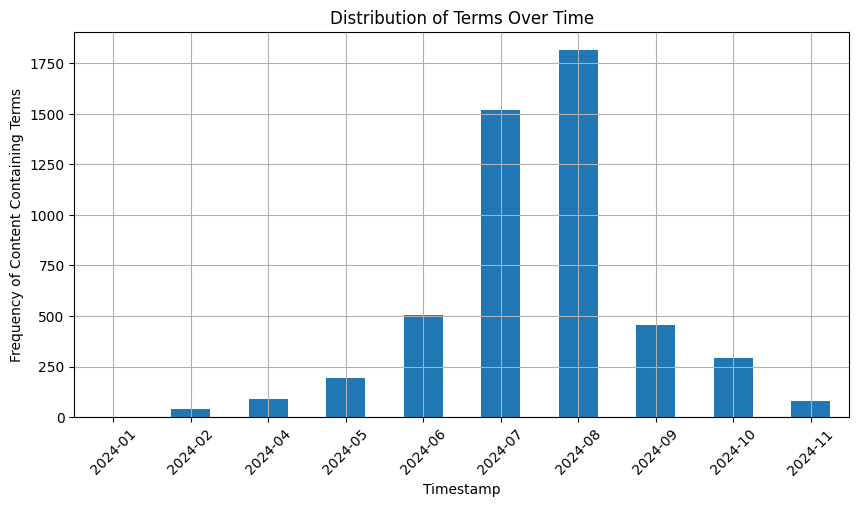

In [ ]:
search_terms = [term[0] for term in closest_terms]
# Regular expression pattern to check for any of the search terms
pattern = '|'.join(search_terms)

# Filter rows where content contains any of the search terms
filtered_df = data[data['content'].str.contains(pattern, case=False, na=False)]

# Count occurrences by timestamp
time_distribution = filtered_df['timestamp'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
time_distribution.plot(kind='bar')
plt.title('Distribution of Terms Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Frequency of Content Containing Terms')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Hands-on: your try (20 min)



Try to find the topics yourself !

# Topic Modeling

### Loading Bunka

In [ ]:
from bunkatopics import Bunka

In [ ]:
# Load Embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-MiniLM-L6-v2", device='cuda') # Chose cuda

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedding_model.device

device(type='cuda', index=0)

In [ ]:
embedding_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [ ]:
data

,content,timestamp,reaction_counts,total_reactions,token_count
21984,"i'm literally hungry right now, like LITERALLY...",2024-08,"{'🔥': 1, '🫡': 1, '👍': 1}",3,25
89007,"Yes, G, but always eager to come here and be w...",2024-08,{'🤝': 1},1,21
82094,"I just kinda started with the coffee g, been d...",2024-08,"{'💪': 1, '🔥': 1}",2,34
339361,"Hello Gs, quick question.\n\nWhat collagen pow...",2024-08,{},0,74
454604,<@01HE55JM7GYB61WDKBTGTYZNSF> and if you train...,2024-07,{},0,46
...,...,...,...,...,...
306049,"Honestly if I were you I would keep it, becaus...",2024-08,{'👍': 1},1,38
99328,GM from the Gym 💪\n\nphotos from today's train...,2024-08,{'👍': 2},2,40
174391,Aight Gs good talking to everyone. I gotta get...,2024-07,"{'👍': 1, '🔥': 1}",2,26
72087,Exactly it’s more annoying than anything else....,2024-08,"{'🔥': 1, '👍': 1}",2,63


## A first Topic modeling using Bunka


In [ ]:
# Load Projection Model
from umap import UMAP

#from umap.umap_ import UMAP

projection_model = UMAP(
                n_components=2,
                random_state=42)

from bunkatopics import Bunka

bunka = Bunka(embedding_model=embedding_model,
            projection_model=projection_model)  # the language is automatically detected, make sure the embedding model is adapted



sampled_data = data.sample(10000, random_state = 42)
#sampled_data = data
docs = sampled_data['content'].to_list()
ids = sampled_data['content'].to_list()
metadata= {'date' : sampled_data['timestamp'].to_list(), 'reactions_count': sampled_data['total_reactions'].to_list() }

# Fit Bunka to your text data
bunka.fit(ids = docs, docs = docs, sampling_size_for_terms = 1000, metadata=metadata)

2024-12-10 10:25:17 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:25:17 - Bunka - INFO - Detected language: English
INFO:Bunka:Detected language: English
2024-12-10 10:25:17 - Bunka - INFO - Embedding documents... (can take varying amounts of time depending on their size)
INFO:Bunka:Embedding documents... (can take varying amounts of time depending on their size)


Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:25:27 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:26:14 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:26:14 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:13<00:00, 73.25it/s]


In [ ]:
from sklearn.cluster import KMeans
clustering_model = KMeans(n_clusters=10)
bunka.get_topics(name_length=5, custom_clustering_model=clustering_model)# Specify the number of terms to describe each topic
fig_MiniLM = bunka.visualize_topics(width=1000, height=1000, colorscale='delta')
fig_MiniLM.show()

Output hidden; open in https://colab.research.google.com to view.

## Comparing clustering algorithms

### Elbow method

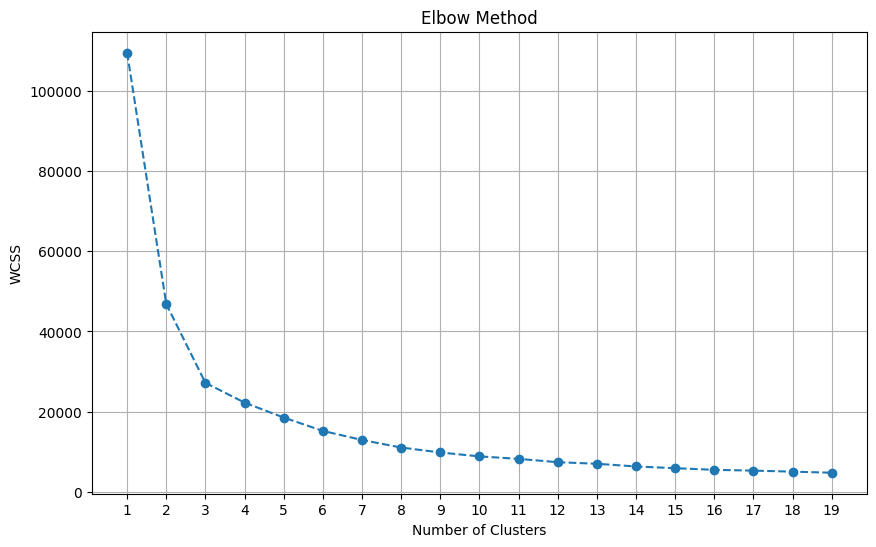

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

embeddings = [[x.x, x.y] for x in bunka.docs]

# Convert data to numpy array
data_array = np.array(embeddings)
data_array.shape

# Calculate WCSS for different values of k
wcss = []
for i in range(1, 20):  # Assuming you want to try up to 6 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_array)
    wcss.append(kmeans.inertia_)



# Plot the elbow method graph
plt.figure(figsize=(10,6))
plt.plot(range(1, 20), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans, HDBSCAN

In [ ]:

max_cluster_size = int(0.2*len(sampled_data))
min_cluster_size = max(int(0.01*len(sampled_data)), 30)

clusterer = HDBSCAN(min_samples = 1,
                max_cluster_size=max_cluster_size,
                min_cluster_size=min_cluster_size,
                metric = 'manhattan',
                #metric = 'euclidean',
                cluster_selection_method = 'eom')

In [ ]:
bunka.get_topics(name_length=5,
                 custom_clustering_model=clusterer,
                 min_count_terms = 2,
                 min_docs_per_cluster=100,
                 top_terms_overall = 1000,
                 )# Specify the number of terms to describe each topic

bunka.visualize_topics(width=1000, height=1000, colorscale='delta')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_topics = bunka.df_topics_
df_topics

,topic_id,topic_name,size,percent
0,bt-4,protein | calories | eggs | beef | foods,1961,26.40
1,bt-5,supplements | doctors | water | hydration | blood,686,9.24
2,bt-14,ups | press | squats | reps | calisthenics,685,9.22
3,bt-1,boxing | skills | coach | bag | punches,527,7.10
4,bt-11,arms | today | biceps | abs | STOP,326,4.39
5,bt-18,video | solutions | everytime | chats | picture,315,4.24
6,bt-10,walk | sprints | roll | bicycle | Rest,305,4.11
7,bt-20,man | brother | hate | hahahah | makin,296,3.99
8,bt-12,brother | training | gym | voice | sickness,252,3.39
9,bt-21,boys | game | worries | killer | trw,202,2.72


## Comparing dimensional reduction algorithms

In [ ]:
from umap import UMAP
from sklearn.manifold import TSNE, MDS
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize different projection models
umap_model = UMAP(n_components=2, random_state=42)
tsne_model = TSNE(n_components=2, random_state=42)
# mds_model = MDS(n_components=2, random_state=42)

# Create Bunka instances for each projection
bunka_umap = Bunka(embedding_model=embedding_model, projection_model=umap_model)
bunka_tsne = Bunka(embedding_model=embedding_model, projection_model=tsne_model)
# bunka_mds = Bunka(embedding_model=embedding_model, projection_model=mds_model)

# Fit and get visualizations
for bunka_instance in [bunka_umap, bunka_tsne]:
    bunka_instance.fit(ids=docs, docs=docs,
                      sampling_size_for_terms=1000,
                      metadata=metadata)
    bunka_instance.get_topics(name_length=5,
                            custom_clustering_model=clustering_model)

fig_umap = bunka_umap.visualize_topics(width=1000, height=1000, colorscale='delta',  show_text=False)
fig_tsne = bunka_tsne.visualize_topics(width=1000, height=1000, colorscale='delta', show_text=False)
# fig_mds = bunka_mds.visualize_topics(width=1000, height=1000, colorscale='delta')

# Create subplot layout
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('UMAP', 't-SNE'))

# Add traces to subplots
for trace in fig_umap.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig_tsne.data:
    fig.add_trace(trace, row=1, col=2)
# for trace in fig_mds.data:
#     fig.add_trace(trace, row=1, col=3)

# Update layout
fig.update_layout(
    height=700,
    width=1300,
    showlegend=True,
    title_text="Comparison of Dimension Reduction Methods"
)

fig.show()

2024-12-10 10:30:04 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:30:04 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
2024-12-10 10:30:04 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/IrG27UvsN5cAAAPo/protein-powder.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/IrG27UvsN5cAAAPo/protein-powder.mp4
2024-12-10 10:30:04 - Bunka - INFO - Detected language: English
INFO:Bunka:Detected language: English
2024-12-10 10:30:04 - Bunka - INFO - Embedding documents... (can take varying amounts of time depending on their size)
INFO:Bunka:Embedding documents... (can take varying amounts of time depending on their size)


Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:30:14 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:30:33 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:30:33 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:12<00:00, 80.60it/s]
2024-12-10 10:30:46 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics
2024-12-10 10:30:48 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:30:48 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
2024-12-10 10:30:49 - Bunka - DEBUG - Could not detect language for document: https://media.teno

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:30:57 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:32:51 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:32:51 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:12<00:00, 81.21it/s]
2024-12-10 10:33:04 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics
2024-12-10 10:33:07 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map
2024-12-10 10:33:07 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


## Comparing embeddings


https://huggingface.co/spaces/mteb/leaderboard

In [ ]:
!pip show sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize embedders
embedders = {
    'MiniLM': SentenceTransformer('all-MiniLM-L6-v2', device='cuda'),
    'MPNet': SentenceTransformer('all-mpnet-base-v2', device='cuda'),
    'AllenAI': SentenceTransformer('allenai-specter', device='cuda')
}

projection_model = UMAP(n_components=2, random_state=42)
figures = {}

# Create Bunka instances and visualizations
for name, embedder in embedders.items():
    bunka_instance = Bunka(embedding_model=embedder, projection_model=projection_model)
    bunka_instance.fit(ids=docs, docs=docs,
                      sampling_size_for_terms=1000,
                      metadata=metadata)
    bunka_instance.get_topics(name_length=5,
                            custom_clustering_model=clustering_model)
    figures[name] = bunka_instance.visualize_topics(width=1000, height=1000, colorscale='delta', show_text = False)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/462k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-12-10 10:36:57 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:36:57 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
2024-12-10 10:36:57 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/IrG27UvsN5cAAAPo/protein-powder.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/IrG27UvsN5cAAAPo/protein-powder.mp4
2024-12-10 10:36:57 - Bunka - INFO - Detected language: English
INFO:Bunka:Detected language: English
2024-12-10 10:36:57 - Bunka - INFO - Embedding documents... (can take varying amounts of time depending on their size)
INFO:Bunka:Embedding documents... (can take varying amounts of time depending on their size)


Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:37:07 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:37:27 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:37:27 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:12<00:00, 78.46it/s]
2024-12-10 10:37:40 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics
2024-12-10 10:37:42 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map
2024-12-10 10:37:42 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:37:43 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
20

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:38:31 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:38:52 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:38:52 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:12<00:00, 80.42it/s]
2024-12-10 10:39:05 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics
2024-12-10 10:39:07 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map
2024-12-10 10:39:08 - Bunka - INFO - Processing 432717 tokens
INFO:Bunka:Processing 432717 tokens
2024-12-10 10:39:08 - Bunka - DEBUG - Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
DEBUG:Bunka:Could not detect language for document: https://media.tenor.com/s1wnF2DiWA0AAAPo/skeptical-futurama.mp4
20

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

2024-12-10 10:39:53 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2024-12-10 10:40:15 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2024-12-10 10:40:15 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:11<00:00, 88.54it/s]
2024-12-10 10:40:28 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics
2024-12-10 10:40:32 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


In [ ]:
  figures['MiniLM']

In [ ]:
  figures['MPNet']

In [ ]:
  figures['AllenAI']

In [ ]:
# Create subplot layout
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=list(embedders.keys()))

# Add traces
for idx, (name, fig_data) in enumerate(figures.items(), 1):
    for trace in fig_data.data:
        fig.add_trace(trace, row=1, col=idx)

# Update layout
fig.update_layout(
    height=700,
    width=1300,
    showlegend=True,
    title_text="Comparison of Embedding Models"
)

fig.show()


# Data drift (introduction)


# Hands on: new crypto dataset, what are the trends ? (1h20)

